<a href="https://colab.research.google.com/github/AnikaZN/DS-Unit-1-Sprint-3-Statistical-Tests-and-Experiments/blob/master/module1-statistics-probability-and-inference/LS_DS_131_Statistics_Probability_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img align="left" src="https://lever-client-logos.s3.amazonaws.com/864372b1-534c-480e-acd5-9711f850815c-1524247202159.png" width=200>
<br></br>
<br></br>

## *Data Science Unit 1 Sprint 3 Assignment 1*

# Apply the t-test to real data

Your assignment is to determine which issues have "statistically significant" differences between political parties in this [1980s congressional voting data](https://archive.ics.uci.edu/ml/datasets/Congressional+Voting+Records). The data consists of 435 instances (one for each congressperson), a class (democrat or republican), and 16 binary attributes (yes or no for voting for or against certain issues). Be aware - there are missing values!

Your goals:

1. Load and clean the data (or determine the best method to drop observations when running tests)
2. Using hypothesis testing, find an issue that democrats support more than republicans with p < 0.01
3. Using hypothesis testing, find an issue that republicans support more than democrats with p < 0.01
4. Using hypothesis testing, find an issue where the difference between republicans and democrats has p > 0.1 (i.e. there may not be much of a difference)

Note that this data will involve *2 sample* t-tests, because you're comparing averages across two groups (republicans and democrats) rather than a single group against a null hypothesis.

Stretch goals:

1. Refactor your code into functions so it's easy to rerun with arbitrary variables
2. Apply hypothesis testing to your personal project data (for the purposes of this notebook you can type a summary of the hypothesis you formed and tested)

In [0]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/voting-records/house-votes-84.data')

df.columns = ['party',
          'handicap_infant',
          'water_cost_share',
          'budget_res_adoption',
          'dr_fee_freeze',
          'el_salvador_aid',
          'schools_religious_groups',
          'anti_satellite_ban',
          'nicaraguan_aid',
          'missile',
          'immigration',
          'fuel_corp_cutback',
          'edu_spending',
          'superfund_sue',
          'crime',
          'exports',
          'south_africa_export_admin']

df.head()



,party,handicap_infant,water_cost_share,budget_res_adoption,dr_fee_freeze,el_salvador_aid,schools_religious_groups,anti_satellite_ban,nicaraguan_aid,missile,immigration,fuel_corp_cutback,edu_spending,superfund_sue,crime,exports,south_africa_export_admin
0,republican,n,y,n,y,y,y,n,n,n,n,n,y,y,y,n,?
1,democrat,?,y,y,?,y,y,n,n,n,n,y,n,y,y,n,n
2,democrat,n,y,y,n,?,y,n,n,n,n,y,n,y,n,n,y
3,democrat,y,y,y,n,y,y,n,n,n,n,y,?,y,y,y,y
4,democrat,n,y,y,n,y,y,n,n,n,n,n,n,y,y,y,y


In [3]:
df.isnull().sum()

party                        0
handicap_infant              0
water_cost_share             0
budget_res_adoption          0
dr_fee_freeze                0
el_salvador_aid              0
schools_religious_groups     0
anti_satellite_ban           0
nicaraguan_aid               0
missile                      0
immigration                  0
fuel_corp_cutback            0
edu_spending                 0
superfund_sue                0
crime                        0
exports                      0
south_africa_export_admin    0
dtype: int64

In [4]:
df['handicap_infant'].value_counts()

n    235
y    187
?     12
Name: handicap_infant, dtype: int64

In [5]:
df['handicap_infant'].value_counts()

n    235
y    187
?     12
Name: handicap_infant, dtype: int64

In [6]:
df = df.drop('south_africa_export_admin', axis=1)
#approx 25% of this data is missing, it seems like it will be difficult to effectively/accurately work with

df.head()

,party,handicap_infant,water_cost_share,budget_res_adoption,dr_fee_freeze,el_salvador_aid,schools_religious_groups,anti_satellite_ban,nicaraguan_aid,missile,immigration,fuel_corp_cutback,edu_spending,superfund_sue,crime,exports
0,republican,n,y,n,y,y,y,n,n,n,n,n,y,y,y,n
1,democrat,?,y,y,?,y,y,n,n,n,n,y,n,y,y,n
2,democrat,n,y,y,n,?,y,n,n,n,n,y,n,y,n,n
3,democrat,y,y,y,n,y,y,n,n,n,n,y,?,y,y,y
4,democrat,n,y,y,n,y,y,n,n,n,n,n,n,y,y,y


In [7]:
final = df.fillna(method='ffill')

final.sample(10)

,party,handicap_infant,water_cost_share,budget_res_adoption,dr_fee_freeze,el_salvador_aid,schools_religious_groups,anti_satellite_ban,nicaraguan_aid,missile,immigration,fuel_corp_cutback,edu_spending,superfund_sue,crime,exports
255,republican,n,n,n,y,y,n,n,n,n,n,n,y,n,y,n
111,democrat,n,?,y,n,n,y,y,y,n,y,n,n,n,n,y
210,republican,n,y,n,y,y,y,n,n,n,y,n,y,y,y,n
415,republican,y,y,n,y,y,y,n,n,n,y,n,n,y,y,n
257,democrat,n,n,y,n,n,n,y,y,y,n,y,n,n,n,y
221,democrat,y,n,y,n,n,n,y,y,y,n,y,n,n,n,y
55,republican,n,y,n,y,y,y,n,n,n,y,y,y,y,y,n
412,republican,y,y,y,y,y,y,y,y,n,y,?,?,?,y,n
224,republican,n,?,n,y,y,y,n,n,n,n,n,y,y,y,n
404,republican,n,n,n,y,y,y,n,n,n,n,n,y,y,y,n


In [8]:
final.isnull().sum()

party                       0
handicap_infant             0
water_cost_share            0
budget_res_adoption         0
dr_fee_freeze               0
el_salvador_aid             0
schools_religious_groups    0
anti_satellite_ban          0
nicaraguan_aid              0
missile                     0
immigration                 0
fuel_corp_cutback           0
edu_spending                0
superfund_sue               0
crime                       0
exports                     0
dtype: int64

In [9]:
final.replace('y', 1, inplace=True)
final.replace('n', 0, inplace=True)

final.head()

,party,handicap_infant,water_cost_share,budget_res_adoption,dr_fee_freeze,el_salvador_aid,schools_religious_groups,anti_satellite_ban,nicaraguan_aid,missile,immigration,fuel_corp_cutback,edu_spending,superfund_sue,crime,exports
0,republican,0,1,0,1,1,1,0,0,0,0,0,1,1,1,0
1,democrat,?,1,1,?,1,1,0,0,0,0,1,0,1,1,0
2,democrat,0,1,1,0,?,1,0,0,0,0,1,0,1,0,0
3,democrat,1,1,1,0,1,1,0,0,0,0,1,?,1,1,1
4,democrat,0,1,1,0,1,1,0,0,0,0,0,0,1,1,1


In [10]:
democrats = final[final['party'] == 'democrat']

democrats.head()

,party,handicap_infant,water_cost_share,budget_res_adoption,dr_fee_freeze,el_salvador_aid,schools_religious_groups,anti_satellite_ban,nicaraguan_aid,missile,immigration,fuel_corp_cutback,edu_spending,superfund_sue,crime,exports
1,democrat,?,1,1,?,1,1,0,0,0,0,1,0,1,1,0
2,democrat,0,1,1,0,?,1,0,0,0,0,1,0,1,0,0
3,democrat,1,1,1,0,1,1,0,0,0,0,1,?,1,1,1
4,democrat,0,1,1,0,1,1,0,0,0,0,0,0,1,1,1
5,democrat,0,1,0,1,1,1,0,0,0,0,0,0,?,1,1


In [11]:
republicans = final[final['party'] == 'republican']

republicans.head()

,party,handicap_infant,water_cost_share,budget_res_adoption,dr_fee_freeze,el_salvador_aid,schools_religious_groups,anti_satellite_ban,nicaraguan_aid,missile,immigration,fuel_corp_cutback,edu_spending,superfund_sue,crime,exports
0,republican,0,1,0,1,1,1,0,0,0,0,0,1,1,1,0
6,republican,0,1,0,1,1,1,0,0,0,0,0,0,1,1,?
7,republican,0,1,0,1,1,1,0,0,0,0,0,1,1,1,0
9,republican,0,1,0,1,1,0,0,0,0,0,?,?,1,1,0
10,republican,0,1,0,1,1,1,0,0,0,0,1,?,1,1,?


In [0]:
from scipy.stats import ttest_ind, ttest_ind_from_stats, ttest_rel
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import style

## **Using hypothesis testing, find an issue that democrats support more than republicans with p < 0.01**

Handicapped infants

In [13]:
republicans['handicap_infant'].describe()

count     167
unique      3
top         0
freq      133
Name: handicap_infant, dtype: int64

In [14]:
democrats['handicap_infant'].describe()

count     267
unique      3
top         1
freq      156
Name: handicap_infant, dtype: int64

In [0]:
dems_infant = np.random.normal(0.599251, 0.490971, 267)
repub_infant = np.random.normal(0.191617, 0.394757, 167)

#mean indicates that Dems support this more frequently

In [16]:
statistic, pvalue = ttest_ind(dems_infant, repub_infant)
print(statistic, pvalue)

#low pvalue means that there is likely to be
#a correlation between party and yes/no vote

8.293964270199092 1.4055245041689971e-15


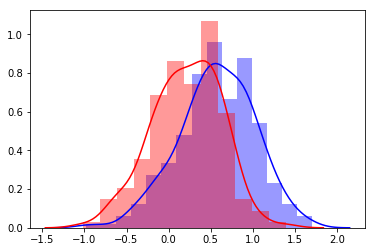

In [17]:
sns.distplot(dems_infant, color='b')
sns.distplot(repub_infant, color='r');

## **Using hypothesis testing, find an issue that republicans support more than democrats with p < 0.01**

Physician fee freeze

In [18]:
republicans['dr_fee_freeze'].describe()

count     167
unique      3
top         1
freq      162
Name: dr_fee_freeze, dtype: int64

In [19]:
democrats['dr_fee_freeze'].describe()

count     267
unique      3
top         0
freq      245
Name: dr_fee_freeze, dtype: int64

In [0]:
dems_drfee = np.random.normal(0.071161, 0.257576, 267)
repub_drfee = np.random.normal(0.988024, 0.109105, 167)

#mean indicates that Republicans support this more frequently

In [21]:
statistic, pvalue = ttest_ind(dems_drfee, repub_drfee)
print(statistic, pvalue)

#super low pvalue means that there is likely to be
#a correlation between party and yes/no vote

-42.23140822239292 1.878192842504575e-155


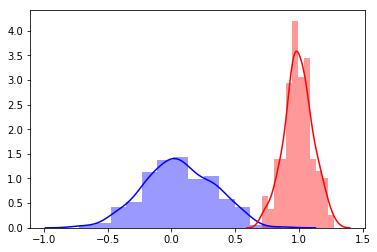

In [22]:
sns.distplot(dems_drfee, color='b')
sns.distplot(repub_drfee, color='r');

## **Using hypothesis testing, find an issue where the difference between republicans and democrats has p > 0.1 (i.e. there may not be much of a difference)**

Water project cost-sharing

In [23]:
republicans['water_cost_share'].describe()

count     167
unique      3
top         1
freq       74
Name: water_cost_share, dtype: int64

In [24]:
democrats['water_cost_share'].describe()

count     267
unique      3
top         1
freq      120
Name: water_cost_share, dtype: int64

In [0]:
dems_water = np.random.normal(0.490637, 0.500851, 267)
repub_water = np.random.normal(0.479042, 0.501063, 167)

#mean indicates that party support is about equal

In [26]:
statistic, pvalue = ttest_ind(dems_water, repub_water)
print(statistic, pvalue)

#high pvalue means that there is not likely to be
#a correlation between party and yes/no vote

-1.0373967660673415 0.3001312937628318


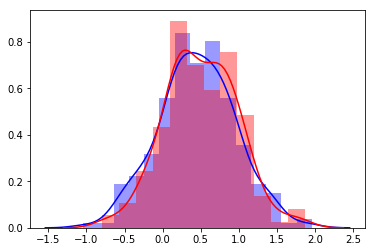

In [27]:
sns.distplot(dems_water, color='b')
sns.distplot(repub_water, color='r');